# Transformer

In [2]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络（Transformer核心组件）"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 ​**kwargs):
        # 初始化父类（继承nn.Module的属性和方法）
        super(PositionWiseFFN, self).__init__(**kwargs)
        
        # 定义第一个全连接层：输入维度 → 隐藏层维度
        # 原理：通过线性变换扩展特征维度
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        
        # ReLU激活函数：引入非线性
        # 记忆点：激活函数置于两个线性层之间是经典设计
        self.relu = nn.ReLU()
        
        # 定义第二个全连接层：隐藏层维度 → 输出维度
        # 作用：将特征维度压缩回目标维度
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        # 前向传播流程
        # 输入X → 全连接层 → ReLU激活 → 全连接层 → 输出
        return self.dense2(self.relu(self.dense1(X)))
        # 维度变化示例：
        # 输入形状：(batch_size, seq_len, ffn_num_input)
        # 输出形状：(batch_size, seq_len, ffn_num_outputs)

"""
初始化三部曲：
父类继承 → 线性层定义 → 激活选择

前向传播两变换：
线性升维 → 激活突破 → 线性降维

维度变化规律：
保留序列长度，变换特征维度
"""

In [6]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.2756,  0.2759,  0.4133, -0.0669, -0.2296, -0.1535,  0.0118,  0.0374],
        [-0.2756,  0.2759,  0.4133, -0.0669, -0.2296, -0.1535,  0.0118,  0.0374],
        [-0.2756,  0.2759,  0.4133, -0.0669, -0.2296, -0.1535,  0.0118,  0.0374]],
       grad_fn=<SelectBackward0>)

In [8]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [10]:
class AddNorm(nn.Module):
    """Transformer残差连接与层归一化组件（Add & Norm）"""
    def __init__(self, normalized_shape, dropout, ​**kwargs):
        """
        初始化函数
        :param normalized_shape: 需要规范化的维度（如特征维度）[3,4](@ref)
        :param dropout: 暂退率（防止过拟合）
        :param kwargs: 父类参数
        """
        # 继承父类属性（所有PyTorch模块的基类）
        super(AddNorm, self).__init__(**kwargs)
        
        # 定义暂退层：随机置零部分神经元输出（正则化作用）[3,4](@ref)
        # 原理：缓解过拟合，增强模型泛化能力
        self.dropout = nn.Dropout(dropout)
        
        # 定义层规范化：对指定维度进行标准化处理[1,3](@ref)
        # 参数说明：normalized_shape决定了归一化的特征维度
        # 例如输入形状为(batch_size, seq_len, 512)，则取512作为特征维度
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        """
        前向传播流程（残差连接+层归一化）
        :param X: 原始输入（残差连接的跳跃输入）
        :param Y: 子层输出（如自注意力或前馈网络的计算结果）
        :return: 规范化后的结果
        """
        # 核心计算步骤（网页1/3/4的实现逻辑）：
        # 1. 对子层输出Y应用暂退（正则化）
        # 2. 执行残差连接：暂退后的Y + 原始输入X
        # 3. 对相加结果进行层归一化
        return self.ln(self.dropout(Y) + X)
        # 维度要求：X和Y必须形状相同
        # 例如输入形状：(batch_size=2, seq_len=3, features=4)

#  残差连接原理 
# 作用：解决深度神经网络中的梯度消失/爆炸问题
# 公式：output = LayerNorm(Y + X)
# 示例：假设X是编码器输入，Y是自注意力计算结果
# 记忆点：像电路中的"短路"，保留原始信息通路

#  层归一化原理 
# 计算步骤：
# 1. 计算特征维度均值μ和方差σ²
# 2. 标准化： (x - μ)/√(σ²+ε)
# 3. 缩放平移：γ * x + β (自动学习参数)
# 作用：稳定数据分布，加速模型收敛


In [12]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [39]:
import torch
import torch.nn as nn

# 假设 d2l 是自定义的深度学习工具包，包含 MultiHeadAttention 类
# 假设 AddNorm 和 PositionWiseFFN 类已经定义
# AddNorm 用于执行残差连接和层归一化操作
# PositionWiseFFN 是一个逐位置的前馈神经网络

class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        """
        编码器块类的初始化函数。编码器块是 Transformer 编码器中的核心组件，
        用于对输入序列进行特征提取和转换。

        参数:
        key_size (int): 键的特征维度。
        query_size (int): 查询的特征维度。
        value_size (int): 值的特征维度。
        num_hiddens (int): 隐藏层的维度，用于多头注意力和前馈网络。
        norm_shape (tuple): 层归一化操作的形状。
        ffn_num_input (int): 前馈神经网络的输入维度。
        ffn_num_hiddens (int): 前馈神经网络隐藏层的维度。
        num_heads (int): 多头注意力中的头数。
        dropout (float): Dropout 概率，用于防止过拟合。
        use_bias (bool): 是否在多头注意力中使用偏置，默认为 False。
        **kwargs: 其他关键字参数，传递给父类的初始化方法。
        """
        # 调用父类的初始化方法
        super(EncoderBlock, self).__init__(**kwargs)
        # 创建多头注意力机制实例
        # 这里假设 MultiHeadAttention 只需要 num_hiddens, num_heads, dropout, use_bias 这些参数
        self.attention = d2l.MultiHeadAttention(
            num_hiddens=num_hiddens,
            num_heads=num_heads,
            dropout=dropout,
            use_bias=use_bias
        )
        # 创建第一个 AddNorm 层，用于在多头注意力之后执行残差连接和层归一化
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 创建逐位置的前馈神经网络实例
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        # 创建第二个 AddNorm 层，用于在前馈神经网络之后执行残差连接和层归一化
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        """
        前向传播函数，定义了编码器块的计算流程。

        参数:
        X (torch.Tensor): 输入序列，形状通常为 (batch_size, seq_len, num_hiddens)。
        valid_lens (torch.Tensor 或 None): 有效长度的张量，用于指定每个样本的有效元素数量。
                                           如果为 None，则不进行遮蔽，直接进行注意力计算。

        返回:
        torch.Tensor: 经过编码器块处理后的输出序列，形状与输入相同。
        """
        # 首先将输入 X 作为查询、键和值输入到多头注意力机制中
        # 得到注意力机制的输出
        # 然后将输入 X 和注意力机制的输出一起输入到第一个 AddNorm 层中
        # 执行残差连接和层归一化操作
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        # 将第一个 AddNorm 层的输出 Y 输入到逐位置的前馈神经网络中
        # 得到前馈神经网络的输出
        # 最后将 Y 和前馈神经网络的输出一起输入到第二个 AddNorm 层中
        # 执行残差连接和层归一化操作，并返回最终结果
        return self.addnorm2(Y, self.ffn(Y))


### 原理和记忆方法

#### 原理
编码器块主要由多头注意力机制、第一个残差连接和层归一化（AddNorm）、逐位置的前馈神经网络以及第二个残差连接和层归一化组成。
- 多头注意力机制可以让模型在不同的子空间中关注输入序列的不同部分，增强模型对序列中元素之间关系的捕捉能力。
- 残差连接（即 `X + 注意力输出` 或 `Y + 前馈网络输出`）有助于缓解梯度消失问题，使模型更容易训练。
- 层归一化可以使模型的训练更加稳定，加速收敛。
- 逐位置的前馈神经网络对每个位置的特征进行独立的非线性变换，进一步提取特征。

#### 记忆方法
1. **初始化部分**：
    - 调用父类初始化方法。
    - 创建多头注意力机制实例。
    - 创建第一个 AddNorm 层。
    - 创建逐位置的前馈神经网络实例。
    - 创建第二个 AddNorm 层。
2. **前向传播部分**：
    - 对输入 `X` 进行多头注意力计算。
    - 使用第一个 AddNorm 层进行残差连接和层归一化，得到 `Y`。
    - 对 `Y` 进行前馈神经网络计算。
    - 使用第二个 AddNorm 层进行残差连接和层归一化，得到最终输出。

### 结果分析
- **特征提取能力**：观察输出序列的特征分布和变化，可以判断编码器块是否有效地提取了输入序列的特征。例如，可以通过可视化输出序列的某些维度，查看不同位置的特征是否有明显的差异，反映出模型对序列中不同元素的区分能力。
- **序列关系捕捉**：可以通过分析注意力权重（如果可以获取），了解模型在不同位置上关注的重点。例如，如果在某个位置上，注意力权重集中在相邻的几个位置，说明模型捕捉到了这些位置之间的紧密关系。
- **模型稳定性**：观察训练过程中的损失曲线和梯度变化情况。如果损失曲线平稳下降，梯度没有出现剧烈波动，说明编码器块中的层归一化和残差连接起到了稳定训练的作用。
- **性能评估**：在具体的任务中（如机器翻译、文本分类等），使用编码器块的模型的性能指标（如准确率、F1 值等）可以反映编码器块的效果。如果性能指标良好，说明编码器块能够有效地将输入序列转换为适合任务的特征表示。 

In [90]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [43]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, ​**kwargs):
        """Transformer编码器实现"""
        # 初始化父类（继承自d2l.Encoder的序列模型基类）
        super(TransformerEncoder, self).__init__(**kwargs)
        
        # 设置隐藏层维度（特征空间维度）
        self.num_hiddens = num_hiddens  # 用于后续的维度一致性校验
        
        # 定义词嵌入层（将离散词索引映射为连续向量）
        # 原理：将词汇表元素映射到语义空间
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        
        # 定义位置编码层（注入序列位置信息）
        # 作用：弥补Transformer无法感知序列顺序的缺陷
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        
        # 构建编码器块堆栈（多层Transformer结构）
        # 设计要点：通过num_layers控制模型深度（网页6建议2-6层）
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),  # 命名规范："block0", "block1"...
                EncoderBlock(
                    key_size,      # 键向量维度（自注意力参数）
                    query_size,     # 查询向量维度 
                    value_size,     # 值向量维度
                    num_hiddens,    # 统一特征维度
                    norm_shape,     # 层归一化的标准化维度（如[-1]）
                    ffn_num_input,  # 前馈网络输入维度
                    ffn_num_hiddens,# 前馈网络隐藏层维度（通常4倍输入）
                    num_heads,      # 多头注意力头数
                    dropout,        # 随机失活率（防过拟合）
                    use_bias))      # 是否在注意力中引入偏置项

    def forward(self, X, valid_lens, *args):
        """前向传播流程（含注意力权重记录）"""
        # 嵌入层处理：词向量 * sqrt(d_model) 保持数值稳定
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        
        # 初始化注意力权重容器（用于可视化分析）
        self.attention_weights = [None] * len(self.blks)
        
        # 逐层处理输入（编码器堆栈传播）
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)  # 执行编码器块计算（含自注意力机制）
            # 保存当前块的注意力权重矩阵（
            self.attention_weights[i] = blk.attention.attention.attention_weights
        
        return X  # 最终编码结果（形状：(batch_size, seq_len, num_hiddens)）

In [45]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [59]:
class DecoderBlock(nn.Module):
    """
    解码器中第 i 个块。解码器块是 Transformer 解码器的核心组件，
    用于在生成目标序列时结合编码器的输出和之前生成的部分序列。
    """
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, use_bias=False, **kwargs):
        """
        初始化解码器块。

        参数:
        key_size (int): 键的特征维度。
        query_size (int): 查询的特征维度。
        value_size (int): 值的特征维度。
        num_hiddens (int): 隐藏层的维度，用于多头注意力和前馈网络。
        norm_shape (tuple): 层归一化操作的形状。
        ffn_num_input (int): 前馈神经网络的输入维度。
        ffn_num_hiddens (int): 前馈神经网络隐藏层的维度。
        num_heads (int): 多头注意力中的头数。
        dropout (float): Dropout 概率，用于防止过拟合。
        i (int): 当前解码器块的索引。
        use_bias (bool): 是否在多头注意力中使用偏置，默认为 False。
        **kwargs: 其他关键字参数，传递给父类的初始化方法。
        """
        # 调用父类的初始化方法
        super(DecoderBlock, self).__init__(**kwargs)
        # 记录当前解码器块的索引
        self.i = i
        # 创建第一个多头注意力机制实例，用于自注意力（关注之前生成的部分序列）
        self.attention1 = d2l.MultiHeadAttention(
            num_hiddens=num_hiddens,
            num_heads=num_heads,
            dropout=dropout,
            use_bias=use_bias
        )
        # 创建第一个 AddNorm 层，用于在自注意力之后执行残差连接和层归一化
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 创建第二个多头注意力机制实例，用于编码器 - 解码器注意力（关注编码器的输出）
        self.attention2 = d2l.MultiHeadAttention(
            num_hiddens=num_hiddens,
            num_heads=num_heads,
            dropout=dropout,
            use_bias=use_bias
        )
        # 创建第二个 AddNorm 层，用于在编码器 - 解码器注意力之后执行残差连接和层归一化
        self.addnorm2 = AddNorm(norm_shape, dropout)
        # 创建逐位置的前馈神经网络实例
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        # 创建第三个 AddNorm 层，用于在前馈神经网络之后执行残差连接和层归一化
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        """
        前向传播函数，定义了解码器块的计算流程。

        参数:
        X (torch.Tensor): 输入序列，形状通常为 (batch_size, seq_len, num_hiddens)。
        state (tuple): 包含编码器的输出、编码器的有效长度和之前生成的键值对。

        返回:
        tuple: 包含经过解码器块处理后的输出序列和更新后的状态。
        """
        # 从状态中提取编码器的输出和编码器的有效长度
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 如果之前生成的键值对为空
        if state[2][self.i] is None:
            # 则将当前输入作为键值对
            key_values = X
        else:
            # 否则，将之前生成的键值对和当前输入在序列长度维度上拼接
            key_values = torch.cat((state[2][self.i], X), axis=1)
        # 更新状态中当前解码器块对应的键值对
        state[2][self.i] = key_values
        # 如果处于训练模式
        if self.training:
            # 获取输入序列的批次大小、序列长度和特征维度
            batch_size, num_steps, _ = X.shape
            # 生成解码器的有效长度，用于掩码注意力，防止看到未来的信息
            dec_valid_lens = torch.arange(1, num_steps + 1,
                                          device=X.device).repeat(
                                              batch_size, 1)
        else:
            # 如果处于推理模式，不需要掩码，有效长度设为 None
            dec_valid_lens = None
        # 执行自注意力，使用当前输入作为查询，键值对作为键和值
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        # 执行第一个 AddNorm 操作，将输入和自注意力的输出进行残差连接和层归一化
        Y = self.addnorm1(X, X2)
        # 执行编码器 - 解码器注意力，使用自注意力的输出作为查询，编码器的输出作为键和值
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        # 执行第二个 AddNorm 操作，将自注意力的输出和编码器 - 解码器注意力的输出进行残差连接和层归一化
        Z = self.addnorm2(Y, Y2)
        # 执行逐位置的前馈神经网络计算
        # 并执行第三个 AddNorm 操作，将编码器 - 解码器注意力的输出和前馈网络的输出进行残差连接和层归一化
        return self.addnorm3(Z, self.ffn(Z)), state

### 原理和记忆方法

#### 原理
解码器块主要由自注意力机制、编码器 - 解码器注意力机制、逐位置的前馈神经网络以及三个残差连接和层归一化（AddNorm）层组成。
- **自注意力机制**：在生成目标序列时，解码器需要关注之前生成的部分序列，通过自注意力机制可以捕捉这些信息。在训练时，使用掩码（`dec_valid_lens`）来防止模型看到未来的信息，保证模型的因果性。
- **编码器 - 解码器注意力机制**：解码器需要结合编码器的输出，通过编码器 - 解码器注意力机制，解码器可以关注编码器输出中与当前生成步骤相关的信息。
- **残差连接和层归一化**：和编码器块类似，残差连接有助于缓解梯度消失问题，层归一化可以使模型的训练更加稳定，加速收敛。
- **逐位置的前馈神经网络**：对每个位置的特征进行独立的非线性变换，进一步提取特征。

#### 记忆方法
1. **初始化部分**：
    - 调用父类初始化方法，记录当前块的索引。
    - 创建自注意力机制和对应的 AddNorm 层。
    - 创建编码器 - 解码器注意力机制和对应的 AddNorm 层。
    - 创建逐位置的前馈神经网络和对应的 AddNorm 层。
2. **前向传播部分**：
    - 处理键值对，根据是否有之前生成的键值对进行拼接。
    - 根据训练或推理模式生成解码器的有效长度。
    - 执行自注意力和第一个 AddNorm 操作。
    - 执行编码器 - 解码器注意力和第二个 AddNorm 操作。
    - 执行逐位置的前馈神经网络和第三个 AddNorm 操作。
    - 返回处理后的输出和更新后的状态。

### 结果分析
- **序列生成质量**：观察生成的目标序列的质量，例如在机器翻译任务中，评估生成的译文是否准确、流畅；在文本生成任务中，评估生成的文本是否符合逻辑和语义。可以使用一些评估指标，如 BLEU 分数（用于机器翻译）、困惑度等。
- **注意力分布**：分析自注意力和编码器 - 解码器注意力的权重分布。自注意力的权重可以反映模型在生成每个位置时对之前生成部分的关注情况；编码器 - 解码器注意力的权重可以反映模型在生成每个位置时对编码器输出中不同部分的关注情况。通过可视化注意力权重，可以了解模型是如何进行信息选择和融合的。
- **模型稳定性**：观察训练过程中的损失曲线和梯度变化情况。如果损失曲线平稳下降，梯度没有出现剧烈波动，说明解码器块中的层归一化和残差连接起到了稳定训练的作用。
- **性能对比**：在相同的任务和数据集上，将使用该解码器块的模型与其他模型进行性能对比。如果该模型在评估指标上表现更好，说明解码器块的设计是有效的。 

In [61]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0, use_bias=False)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape
torch.Size([2, 100, 24])

torch.Size([2, 100, 24])

In [63]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        """
        初始化 Transformer 解码器。

        参数:
        vocab_size (int): 词汇表的大小。
        key_size (int): 键的特征维度。
        query_size (int): 查询的特征维度。
        value_size (int): 值的特征维度。
        num_hiddens (int): 隐藏层的维度。
        norm_shape (tuple): 层归一化操作的形状。
        ffn_num_input (int): 前馈神经网络的输入维度。
        ffn_num_hiddens (int): 前馈神经网络隐藏层的维度。
        num_heads (int): 多头注意力中的头数。
        num_layers (int): 解码器块的层数。
        dropout (float): Dropout 概率，用于防止过拟合。
        **kwargs: 其他关键字参数，传递给父类的初始化方法。
        """
        # 调用父类 AttentionDecoder 的初始化方法
        super(TransformerDecoder, self).__init__(**kwargs)
        # 记录隐藏层的维度
        self.num_hiddens = num_hiddens
        # 记录解码器块的层数
        self.num_layers = num_layers
        # 创建嵌入层，将输入的词索引转换为词向量，词向量维度为 num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 创建位置编码层，为输入序列添加位置信息，防止模型丢失顺序信息
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 创建一个 Sequential 容器，用于存储多个解码器块
        self.blks = nn.Sequential()
        # 循环创建 num_layers 个解码器块，并添加到 Sequential 容器中
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        # 创建一个全连接层，将解码器的输出映射到词汇表大小的维度，用于预测下一个词
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        """
        初始化解码器的状态。

        参数:
        enc_outputs (torch.Tensor): 编码器的输出。
        enc_valid_lens (torch.Tensor): 编码器输出的有效长度。
        *args: 其他可能的参数。

        返回:
        list: 包含编码器输出、编码器有效长度和每层解码器块初始状态的列表。
        """
        # 初始化每层解码器块的状态为 None
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        """
        前向传播函数，定义了解码器的计算流程。

        参数:
        X (torch.Tensor): 输入的词索引序列，形状通常为 (batch_size, seq_len)。
        state (list): 解码器的状态。

        返回:
        tuple: 包含解码器的输出和更新后的状态。
        """
        # 将输入的词索引通过嵌入层转换为词向量，并乘以隐藏层维度的平方根进行缩放
        # 然后通过位置编码层添加位置信息
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # 初始化注意力权重列表，用于记录每层解码器块的自注意力和编码器 - 解码器注意力的权重
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        # 遍历每个解码器块
        for i, blk in enumerate(self.blks):
            # 将输入和状态传入解码器块进行计算，得到更新后的输入和状态
            X, state = blk(X, state)
            # 记录当前解码器块的自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # 记录当前解码器块的编码器 - 解码器注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        # 将解码器的输出通过全连接层映射到词汇表大小的维度
        return self.dense(X), state

    @property
    def attention_weights(self):
        """
        获取注意力权重。

        返回:
        list: 包含每层解码器块的自注意力和编码器 - 解码器注意力的权重。
        """
        return self._attention_weights


### 原理和记忆方法

#### 原理
Transformer 解码器主要由嵌入层、位置编码层、多个解码器块和解码器输出层组成。
- **嵌入层**：将输入的词索引转换为词向量，使得模型能够处理文本数据。
- **位置编码层**：为输入序列添加位置信息，因为 Transformer 模型本身不具备对序列顺序的感知能力，位置编码可以帮助模型捕捉序列中的顺序关系。
- **解码器块**：每个解码器块包含自注意力机制、编码器 - 解码器注意力机制、逐位置的前馈神经网络以及残差连接和层归一化层。自注意力机制用于关注之前生成的部分序列，编码器 - 解码器注意力机制用于结合编码器的输出，前馈神经网络用于进一步提取特征。
- **解码器输出层**：将解码器的输出映射到词汇表大小的维度，用于预测下一个词。

#### 记忆方法
1. **初始化部分**：
    - 调用父类初始化方法。
    - 记录隐藏层维度和层数。
    - 创建嵌入层、位置编码层。
    - 循环创建多个解码器块并添加到 Sequential 容器中。
    - 创建全连接层作为解码器输出层。
2. **初始化状态部分**：
    - 初始化每层解码器块的状态为 None。
3. **前向传播部分**：
    - 对输入的词索引进行嵌入和位置编码。
    - 初始化注意力权重列表。
    - 遍历每个解码器块，进行计算并记录注意力权重。
    - 将解码器的输出通过全连接层映射到词汇表大小的维度。
4. **获取注意力权重部分**：
    - 通过属性方法返回注意力权重列表。

### 结果分析
- **生成结果质量**：观察生成的文本序列的质量，例如在机器翻译任务中，评估生成的译文是否准确、流畅；在文本生成任务中，评估生成的文本是否符合逻辑和语义。可以使用一些评估指标，如 BLEU 分数（用于机器翻译）、困惑度等。
- **注意力权重分析**：分析自注意力和编码器 - 解码器注意力的权重分布。自注意力的权重可以反映模型在生成每个位置时对之前生成部分的关注情况；编码器 - 解码器注意力的权重可以反映模型在生成每个位置时对编码器输出中不同部分的关注情况。通过可视化注意力权重，可以了解模型是如何进行信息选择和融合的。
- **模型收敛情况**：观察训练过程中的损失曲线。如果损失曲线平稳下降，说明模型能够正常收敛；如果损失曲线波动较大或不下降，可能需要调整模型的超参数，如学习率、层数、头数等。
- **性能对比**：在相同的任务和数据集上，将使用该解码器的模型与其他模型进行性能对比。如果该模型在评估指标上表现更好，说明解码器的设计是有效的。 

In [69]:
import torch
import torch.nn as nn
# 假设 d2l 是自定义的深度学习工具包，包含 MaskedSoftmaxCELoss、Animator、Timer、Accumulator、concat、grad_clipping 等类和函数

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """
    训练序列到序列（seq2seq）模型。

    参数:
    net (nn.Module): 要训练的 seq2seq 模型。
    data_iter (DataLoader): 数据迭代器，用于批量加载训练数据。
    lr (float): 学习率，控制模型参数更新的步长。
    num_epochs (int): 训练的轮数。
    tgt_vocab (Vocab): 目标语言的词汇表，用于处理目标序列。
    device (torch.device): 训练设备，如 'cpu' 或 'cuda'。
    """
    def xavier_init_weights(m):
        """
        使用 Xavier 初始化方法初始化模型的权重。
        Xavier 初始化可以使模型在训练初期具有合适的权重分布，有助于缓解梯度消失和梯度爆炸问题。

        参数:
        m (nn.Module): 模型的一个模块。
        """
        # 如果模块是全连接层
        if type(m) == nn.Linear:
            # 使用 Xavier 均匀分布初始化全连接层的权重
            nn.init.xavier_uniform_(m.weight)
        # 如果模块是 GRU 层
        if type(m) == nn.GRU:
            # 遍历 GRU 层的所有参数
            for param in m._flat_weights:
                # 如果参数是二维的（权重矩阵）
                if param.ndim == 2:
                    # 使用 Xavier 均匀分布初始化该参数
                    nn.init.xavier_uniform_(param)
    # 对模型的所有模块应用 Xavier 初始化方法
    net.apply(xavier_init_weights)
    # 将模型移动到指定的设备上
    net.to(device)
    # 创建 Adam 优化器，用于更新模型的参数
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    # 创建掩码交叉熵损失函数，用于处理序列中的填充部分
    loss = d2l.MaskedSoftmaxCELoss()
    # 将模型设置为训练模式
    net.train()
    # 创建一个动画绘制器，用于可视化训练过程中的损失变化
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs])
    # 开始训练循环，训练 num_epochs 轮
    for epoch in range(num_epochs):
        # 创建一个计时器，用于记录每一轮的训练时间
        timer = d2l.Timer()
        # 创建一个累加器，用于累加损失和样本数量
        metric = d2l.Accumulator(2)
        # 遍历数据迭代器中的每个批次
        for batch in data_iter:
            # 将批次中的数据移动到指定的设备上
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            # 创建一个张量，包含目标序列的起始标记（<bos>），形状为 (batch_size, 1)
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            # 使用教师强制（Teacher forcing）方法构建解码器的输入
            # 将起始标记和目标序列的除最后一个词之外的部分拼接起来
            dec_input = d2l.concat([bos, Y[:, :-1]], 1)
            # 调试信息：打印解码器输入的形状
            print("dec_input shape:", dec_input.shape)
            # 前向传播：将输入数据和有效长度传入模型，得到模型的输出
            output = net(X, dec_input, X_valid_len)
            # 调试信息：打印输出的类型
            print("output type:", type(output))
            # 调试信息：打印输出的形状，如果输出是张量则直接打印形状，否则打印每个元素的形状
            print("output shape:", output.shape if isinstance(output, torch.Tensor) else [o.shape for o in output])
            # 解包输出：如果输出是元组，则取第一个元素作为预测结果
            if isinstance(output, tuple):
                Y_hat, _ = output
            else:
                Y_hat = output
            # 计算损失：使用掩码交叉熵损失函数计算预测结果和真实标签之间的损失
            l = loss(Y_hat, Y, Y_valid_len)
            # 反向传播：计算损失的梯度
            l.sum().backward()
            # 梯度裁剪：防止梯度爆炸，将梯度的范数限制在 1 以内
            d2l.grad_clipping(net, 1)
            # 更新模型参数：使用优化器更新模型的参数
            optimizer.step()
            # 累加损失和样本数量
            metric.add(l.sum(), l.numel())
        # 每 10 轮打印一次训练信息
        if (epoch + 1) % 10 == 0:
            print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')
        # 更新动画绘制器，显示当前轮的损失
        animator.add(epoch + 1, (metric[0] / metric[1],))


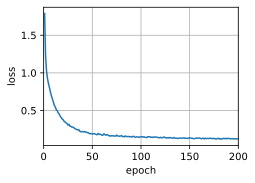

In [71]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [73]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [75]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

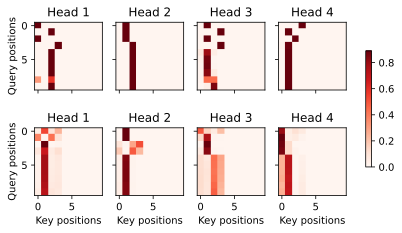

In [77]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

In [79]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

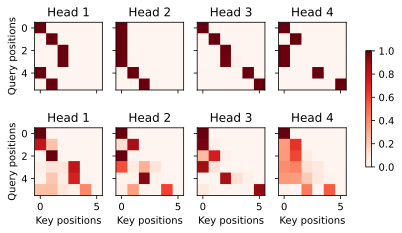

In [81]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

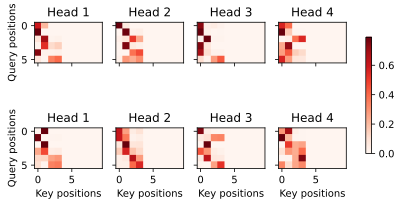

In [83]:
d2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))